In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 2.7243242263793945
(1126, 1, 88200)


In [12]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, c_targets, test_size=0.20, random_state=42)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 6s 3s/step - loss: 1424.6321
(1, 88200)


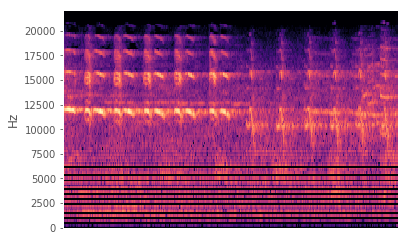

(1126, 128, 345)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_1 (Spectrogra (None, 257, 345, 1)       263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 118ms/step - loss: 1169.5593
(1, 88200)


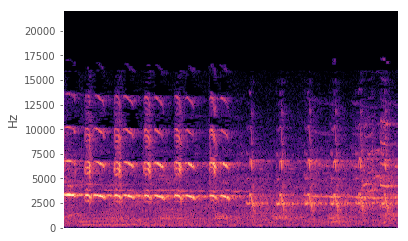

(1126, 257, 345)


In [14]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, c_data[1])
spec = evaluate_model(model, c_data)

# Deep Net
Separate into classes

In [15]:
import librosa

def preprocess(mel_spec, spec):
    # Calculate the first 13 mfcc's
    mfccs = librosa.feature.mfcc(S=mel_spec, n_mfcc=13)
    # Get first derivative of the mfccs
    delta = librosa.feature.delta(mfccs)
    # Get second derivative of mfccs
    delta_2 = librosa.feature.delta(mfccs, order=2)
    
    spec_contrast = librosa.feature.spectral_contrast(S=spec)
    
    return np.vstack((mfccs[1:], delta, delta_2, spec_contrast)).transpose()

In [17]:
start_time = time.time()

new_dat = []
for i in range(0, spec.shape[0]):
    new_dat.append(preprocess(mfccs[i], spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(345, 45)
	Processing Time: 15.64298939704895


In [18]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(1126, 45)


In [21]:
print(c_targets.shape)

(1126,)


In [22]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, c_targets, test_size=0.20, random_state=56)

In [23]:
from keras.layers import Dense, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [24]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5888      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

765/765 [==============================] - 0s 88us/step - loss: 2.1992 - acc: 0.3412 - val_loss: 2.2523 - val_acc: 0.3333
Epoch 50/200
765/765 [==============================] - 0s 88us/step - loss: 2.1189 - acc: 0.3752 - val_loss: 2.2361 - val_acc: 0.3111
Epoch 51/200
765/765 [==============================] - 0s 94us/step - loss: 2.1156 - acc: 0.3582 - val_loss: 2.2101 - val_acc: 0.3185
Epoch 52/200
765/765 [==============================] - 0s 131us/step - loss: 2.1741 - acc: 0.3529 - val_loss: 2.2275 - val_acc: 0.3037
Epoch 53/200
765/765 [==============================] - 0s 104us/step - loss: 2.0931 - acc: 0.3791 - val_loss: 2.2108 - val_acc: 0.3111
Epoch 54/200
765/765 [==============================] - 0s 81us/step - loss: 2.0607 - acc: 0.4013 - val_loss: 2.2059 - val_acc: 0.3259
Epoch 55/200
765/765 [==============================] - 0s 84us/step - loss: 1.9933 - acc: 0.4052 - val_loss: 2.1611 - val_acc: 0.3704
Epoch 56/200
765/765 [==============================] - 0s 129us/s

765/765 [==============================] - 0s 76us/step - loss: 1.3852 - acc: 0.5686 - val_loss: 1.6197 - val_acc: 0.4815
Epoch 110/200
765/765 [==============================] - 0s 85us/step - loss: 1.4102 - acc: 0.5660 - val_loss: 1.6328 - val_acc: 0.4889
Epoch 111/200
765/765 [==============================] - 0s 85us/step - loss: 1.4720 - acc: 0.5490 - val_loss: 1.6301 - val_acc: 0.4741
Epoch 112/200
765/765 [==============================] - 0s 93us/step - loss: 1.4503 - acc: 0.5490 - val_loss: 1.6292 - val_acc: 0.4815
Epoch 113/200
765/765 [==============================] - 0s 86us/step - loss: 1.4392 - acc: 0.5634 - val_loss: 1.5872 - val_acc: 0.4889
Epoch 114/200
765/765 [==============================] - 0s 87us/step - loss: 1.3791 - acc: 0.5791 - val_loss: 1.5618 - val_acc: 0.5037
Epoch 115/200
765/765 [==============================] - 0s 86us/step - loss: 1.4010 - acc: 0.5608 - val_loss: 1.5319 - val_acc: 0.5259
Epoch 116/200
765/765 [==============================] - 0s 85

765/765 [==============================] - 0s 85us/step - loss: 1.0895 - acc: 0.6536 - val_loss: 1.3764 - val_acc: 0.5926
Epoch 170/200
765/765 [==============================] - 0s 85us/step - loss: 1.0479 - acc: 0.6706 - val_loss: 1.3907 - val_acc: 0.5852
Epoch 171/200
765/765 [==============================] - 0s 89us/step - loss: 1.0609 - acc: 0.6601 - val_loss: 1.3912 - val_acc: 0.5852
Epoch 172/200
765/765 [==============================] - 0s 91us/step - loss: 1.0384 - acc: 0.6706 - val_loss: 1.3529 - val_acc: 0.5778
Epoch 173/200
765/765 [==============================] - 0s 89us/step - loss: 1.0475 - acc: 0.6680 - val_loss: 1.3730 - val_acc: 0.5852
Epoch 174/200
765/765 [==============================] - 0s 123us/step - loss: 0.9745 - acc: 0.6980 - val_loss: 1.3647 - val_acc: 0.6074
Epoch 175/200
765/765 [==============================] - 0s 133us/step - loss: 1.0249 - acc: 0.6758 - val_loss: 1.3348 - val_acc: 0.6296
Epoch 176/200
765/765 [==============================] - 0s 

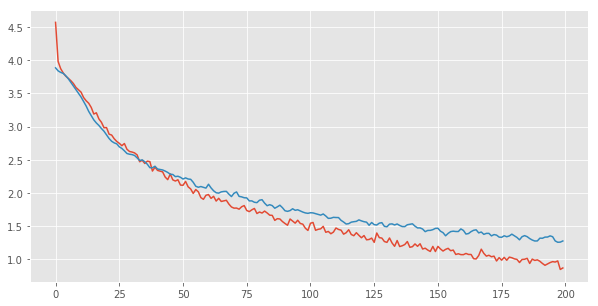

In [25]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

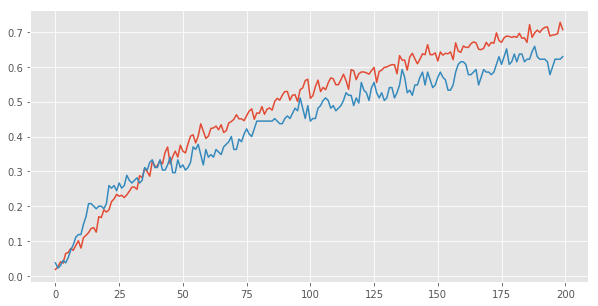

In [26]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.584070796460177
Confusion matrix, without normalization
[[2 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 1 1 ... 0 2 0]
 [0 0 0 ... 0 0 3]]


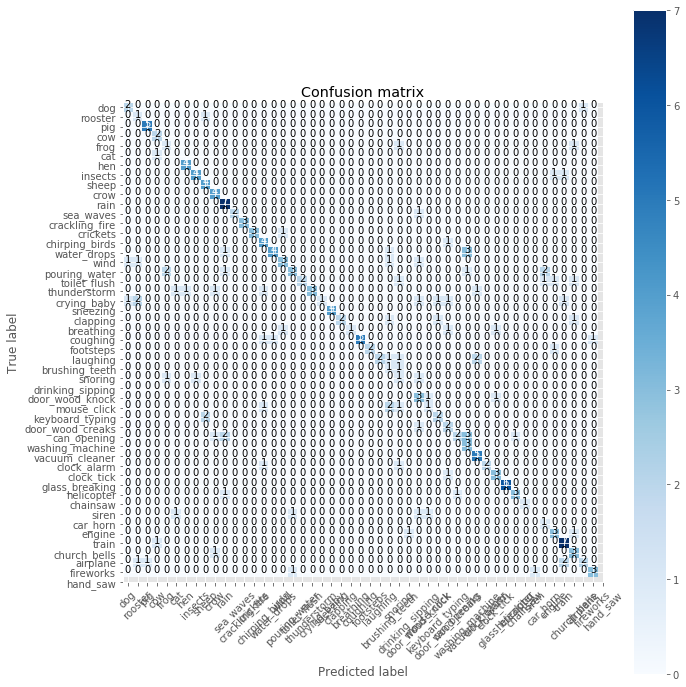

In [29]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

# All Data

In [30]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 2.8944571018218994
	Processing Time: 3.529723644256592
	Processing Time: 2.878840923309326
	Processing Time: 2.839442729949951


In [31]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(4538, 1, 88200)


In [32]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(4538,)


In [33]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(4538,)


________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_2 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 215ms/step - loss: 1428.8843
(1, 88200)


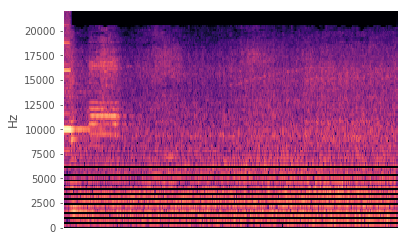

(4538, 128, 345)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_2 (Spectrogra (None, 257, 345, 1)       263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 1s 267ms/step - loss: 1170.5654
(1, 88200)


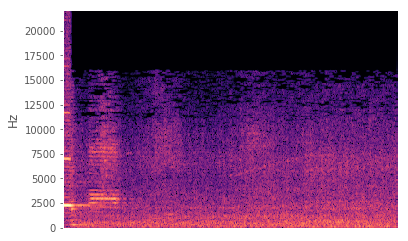

(4538, 257, 345)


In [34]:
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, X[1])
mfccs = evaluate_model(model, X)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, X[1])
spec = evaluate_model(model, X)

In [36]:
start_time = time.time()

new_dat = []
for i in range(0, spec.shape[0]):
    new_dat.append(preprocess(mfccs[i], spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(345, 45)
	Processing Time: 63.06559729576111


In [37]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(4538, 45)


In [38]:
print(yy.shape)

(4538,)


0.19127368884971352
Confusion matrix, without normalization
[[28  7  0 ...  0  4  0]
 [ 9 33  0 ...  0  1  1]
 [ 0  0 20 ...  3  0  4]
 ...
 [ 0  0  4 ... 12  1  0]
 [ 1  3  0 ...  3  2  0]
 [ 0  1  1 ...  0  0  5]]


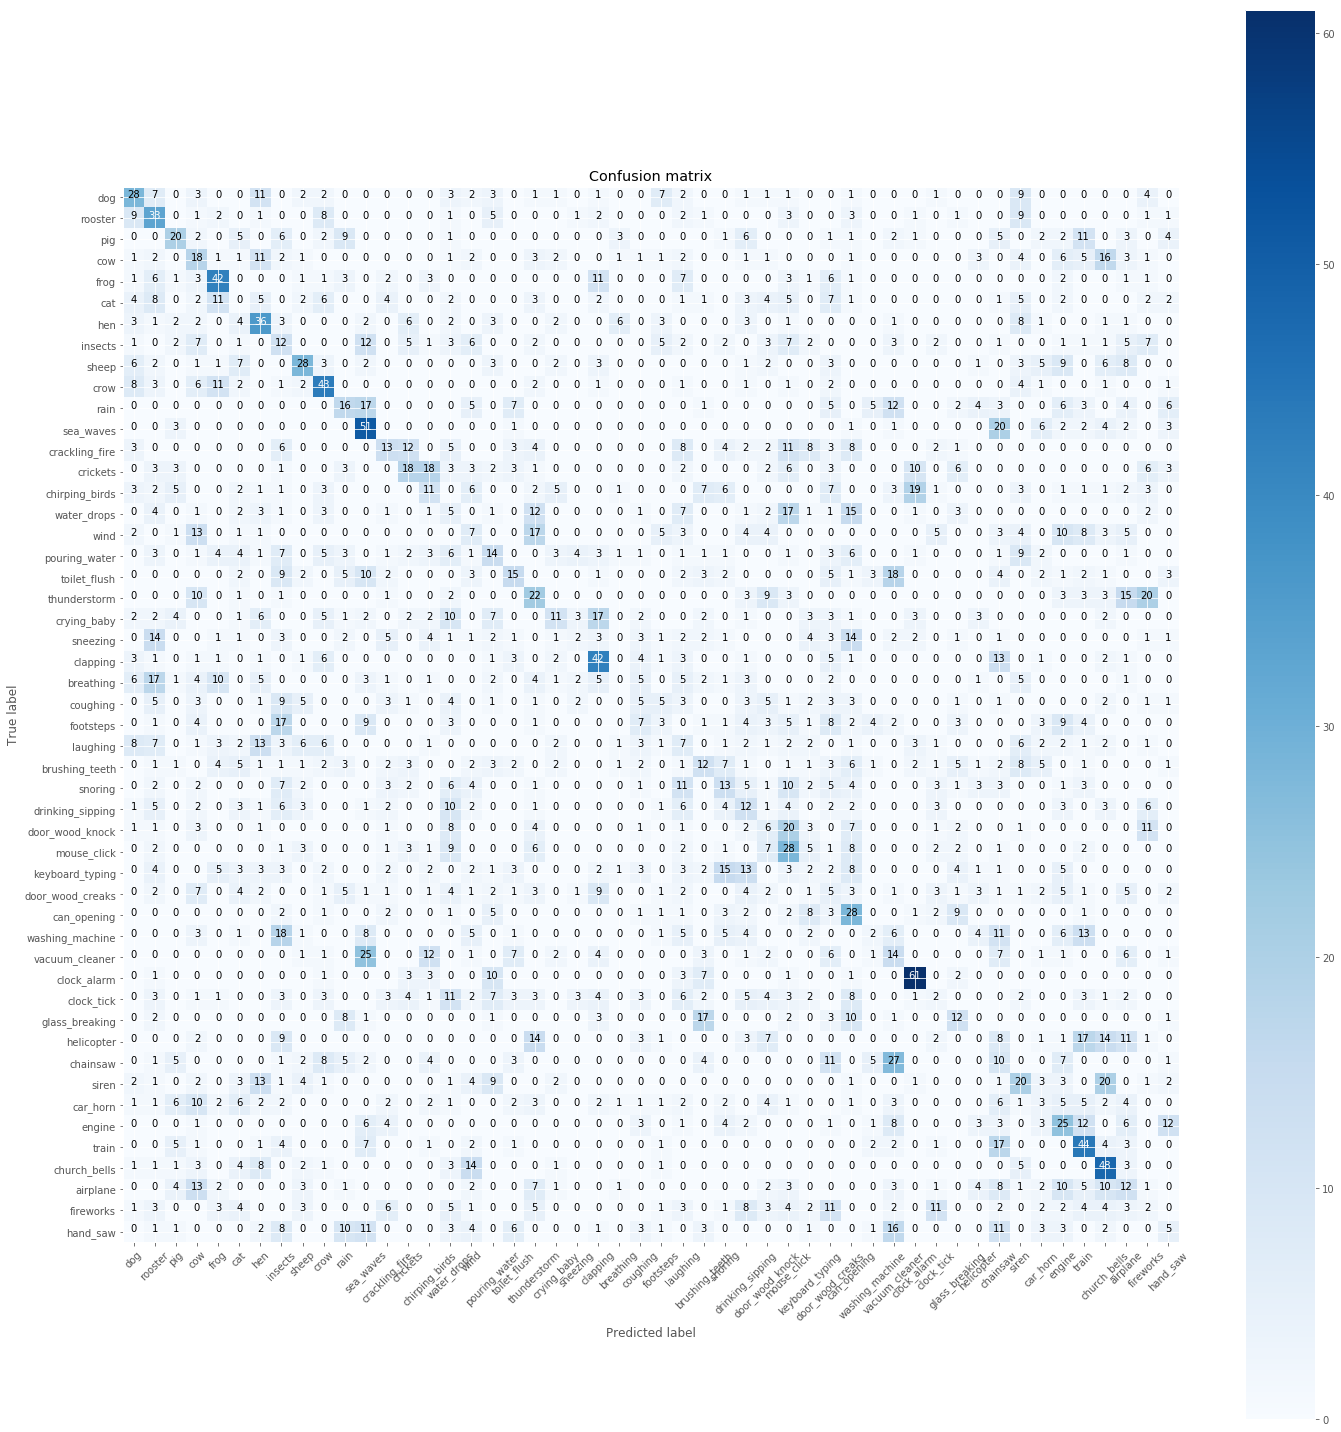

In [40]:
pred = anim.predict(new_dat)
print(metrics.accuracy_score(yy, pred))
cm = metrics.confusion_matrix(yy, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()